In [123]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
from scipy import fftpack
from tabulate import tabulate
%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)
plt.rcParams.update({'font.size': 7})

### Import data
copy the data file from postProcessing/forces/0/coefficient.data to ./data folder

In [124]:
f_name = "/postProcessing/forces/0/coefficient.dat"
fo_name = "plot_data/cases/"
cases = ['case_100','case_200','case_400']
mesh_size = np.array([100, 200, 400])
data = {}
for case in cases:
    data[case] = np.loadtxt(fo_name+case+f_name, unpack=True, usecols=[0, 1, 3])

#### Loading only Cd and Cl

mean drag/lift for case_100: 3.0610/-0.0907
mean drag/lift for case_200: 3.1721/-0.0127
mean drag/lift for case_400: 3.1753/-0.0165
Frequency peak at f=2.25
Frequency peak at f=4.50
Frequency peak at f=4.50


'ax1.set_xlabel("$St$")\nax1.set_ylabel("power")\nax1.set_xlim(0, 1)\nax1.set_ylim(0, 110)\nax1.legend()'

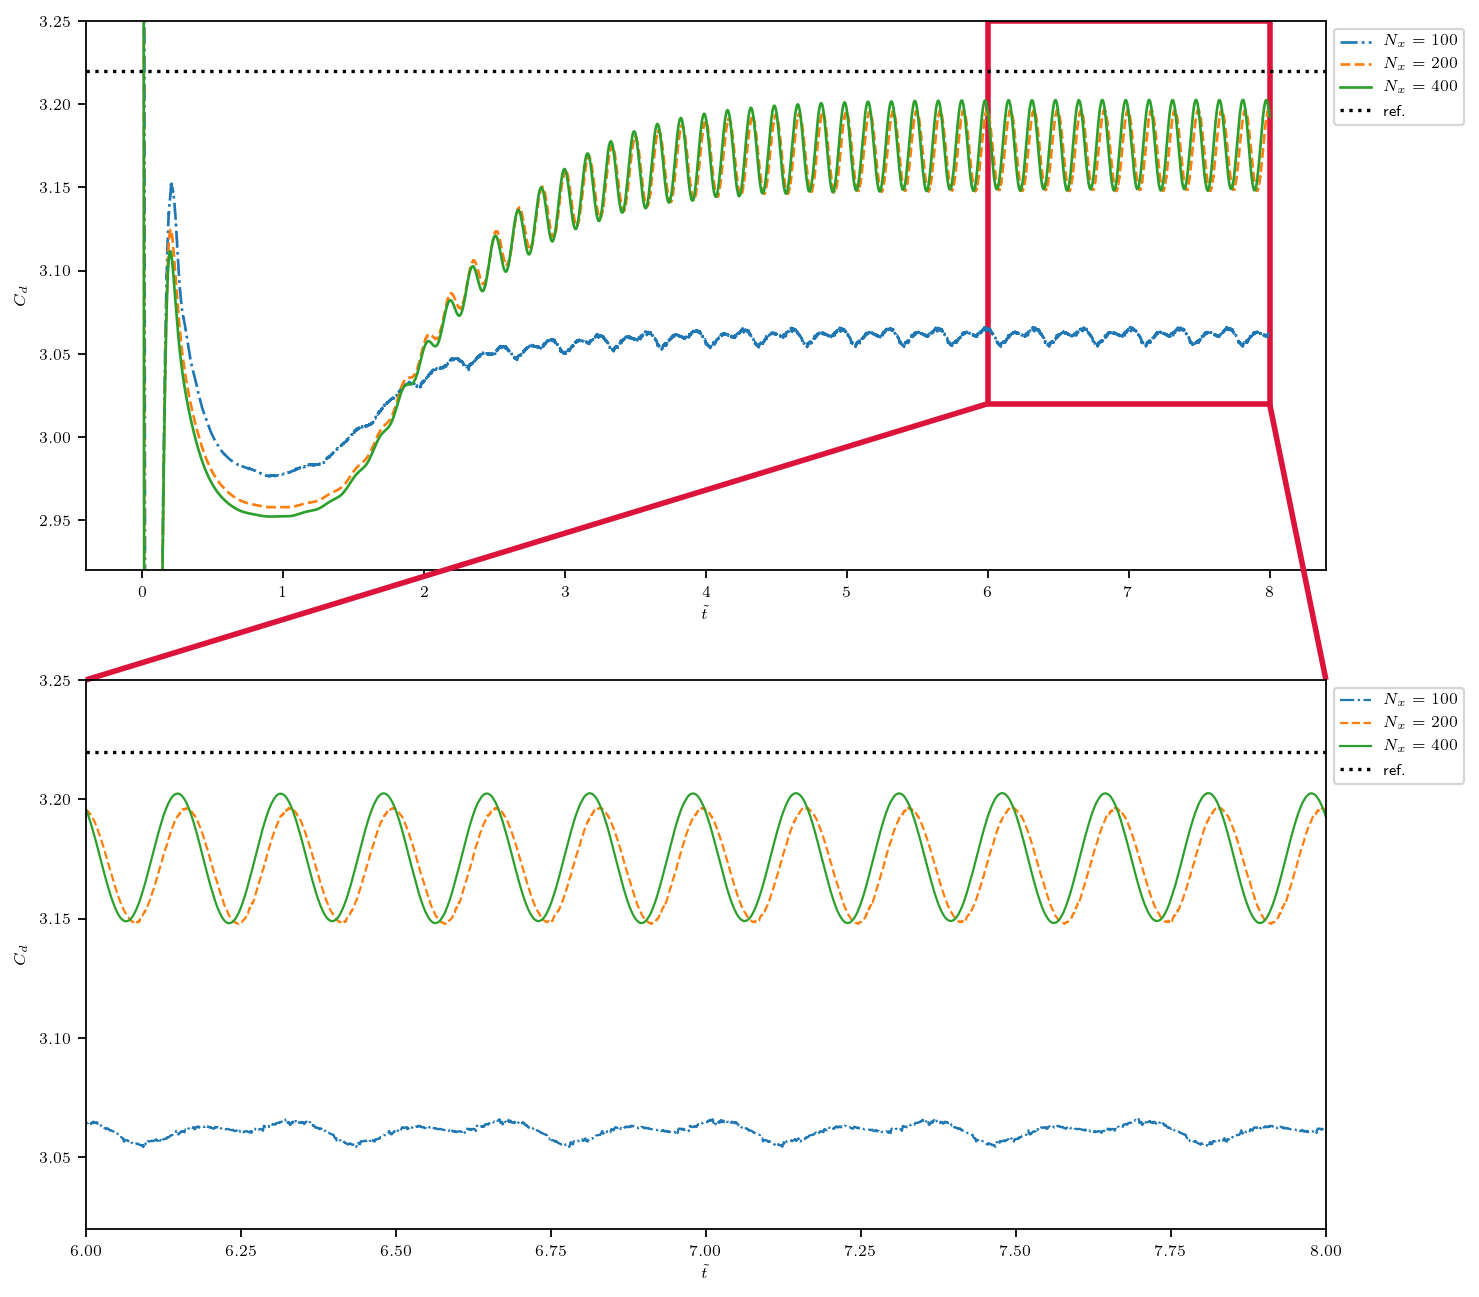

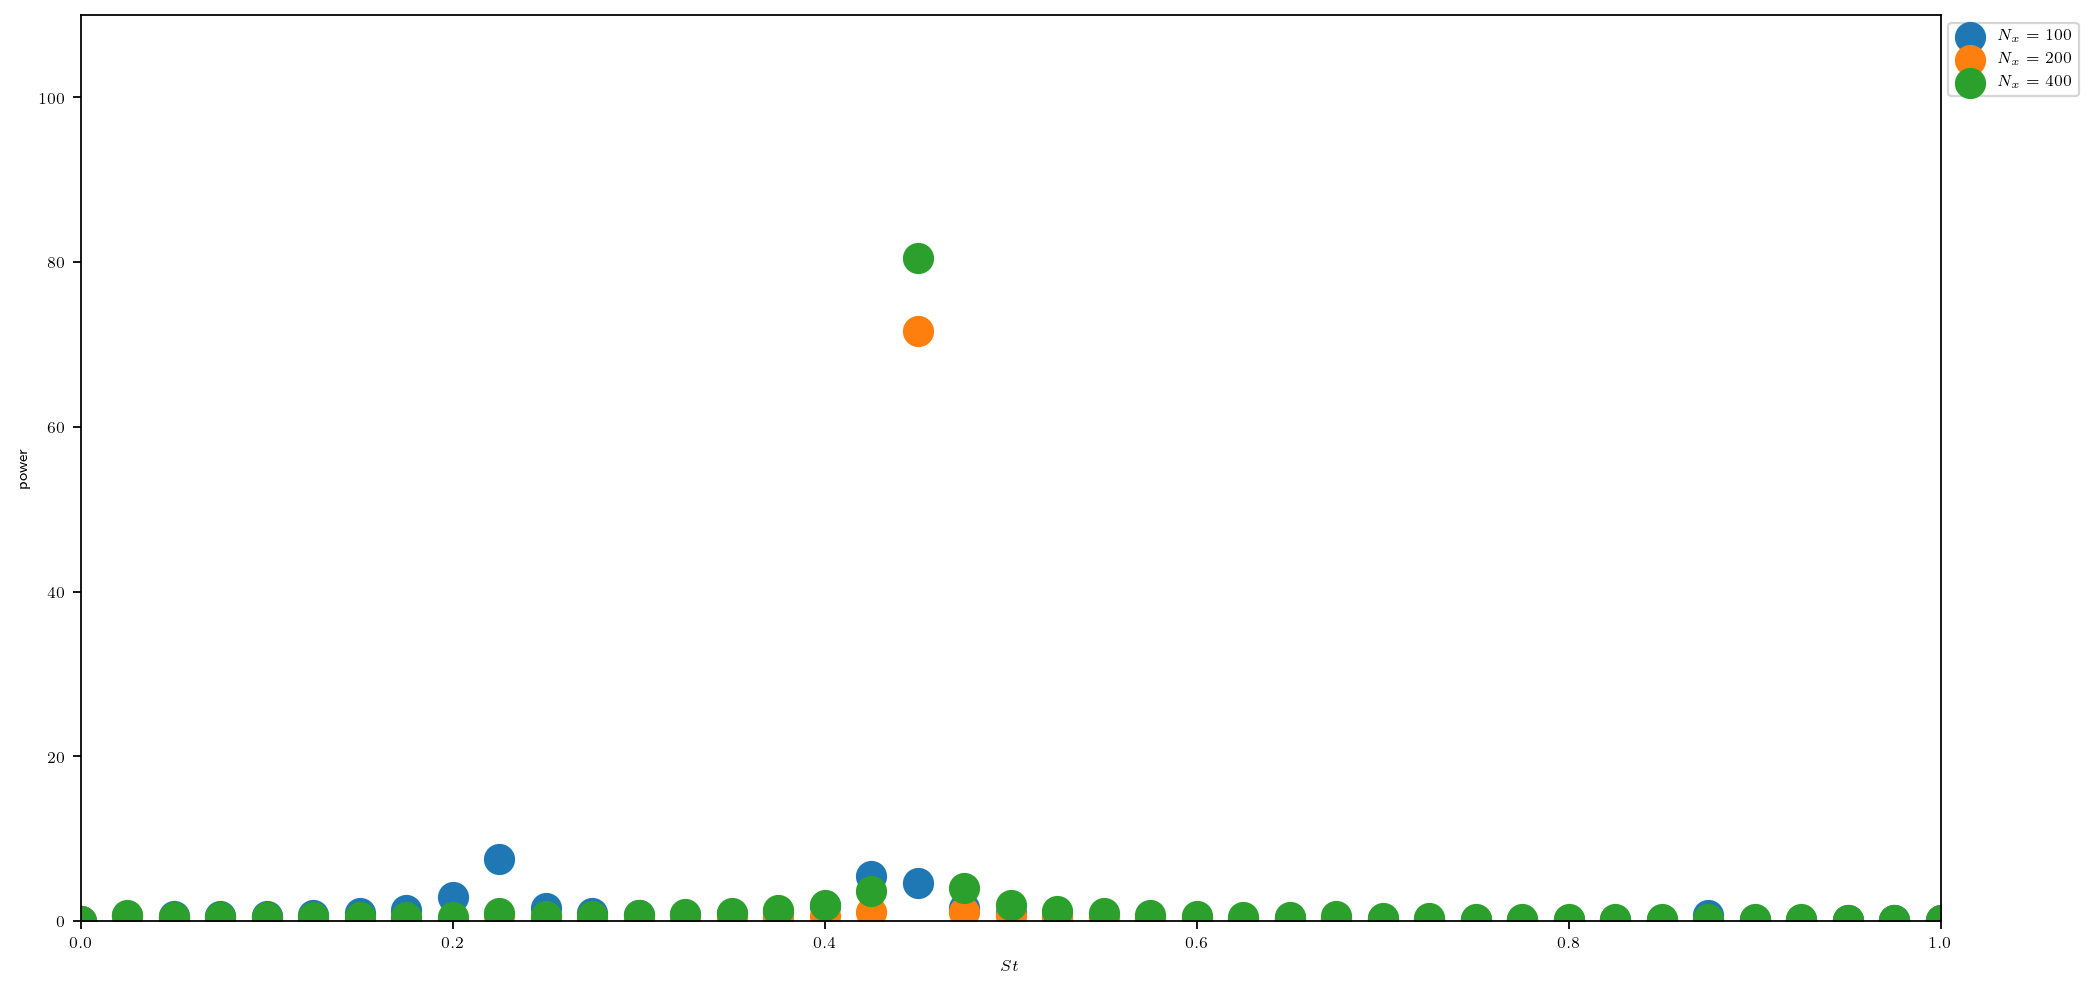

In [125]:
cd_zero_mean = {}
cl_zero_mean = {}
fft_cd = {}
fft_cl = {}

tml = (np.abs(list(data.values())[0][0] - 5.0)).argmin()
markers = ["o","+","s"]
lines = ['-.',"--","-"]
colors = ['#047495',"teal",'#c04e01'] 

diameter = 0.1
labels = [r'$N_x={:d}$'.format(cells) for cells in [100, 200,400]]

fig, (ax, axins) = plt.subplots(nrows=2,figsize=(10,10))
for i, case in enumerate(cases):
    ax.plot(data[case][0],data[case][1], lines[i], linewidth=1.2, markevery=70, label=labels[i])
    axins.plot(data[case][0],data[case][1],lines[i], linewidth=1, markevery=70,  label=labels[i])
axins.set_xlim((6,8))
ax.set_ylim((2.92,3.25))
axins.set_ylim((3.02, 3.25))
ax.axhline(3.22, ls=":", markevery=0.05, color="k", label="ref.")
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
axins.axhline(3.22, ls=":", color="k", label="ref.")
axins.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, linewidth=2.5, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, linewidth=2.5, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, linewidth=2.5, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

mark_inset(ax, axins, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="crimson") 

ax.set_ylabel(r"$C_d$")
ax.set_xlabel(r"$\tilde{t}$")
axins.set_ylabel(r"$C_d$")
axins.set_xlabel(r"$\tilde{t}$")

for i, case in enumerate(cases):
    cd_zero_mean[case] = data[case][1][tml:] - data[case][1][tml:].mean()
    cl_zero_mean[case] = data[case][2][tml:] - data[case][2][tml:].mean()
    print("mean drag/lift for {:s}: {:2.4f}/{:2.4f}".format(case, np.round(data[case][1][tml:].mean(), 4), np.round(data[case][2][tml:].mean(), 4)))

for i, case in enumerate(cases):
    time_step = (8.0 - 4.0) / data[case][0][tml:].shape[0]
    # drag
    cd_fft = fftpack.fft(cd_zero_mean[case])
    sample_freq = fftpack.fftfreq(cd_fft.size, d=time_step)
    fft_cd[case] = (sample_freq, np.abs(cd_fft))
    # lift
    cl_fft = fftpack.fft(cl_zero_mean[case])
    fft_cl[case] = (sample_freq, np.abs(cl_fft))


fig, (ax) = plt.subplots(1, 1, figsize=(15, 7.5))
for i, case in enumerate(cases):
    freq, power = fft_cd[case]
    ax.scatter(freq[:100] * diameter, power[:100], s=170, label=labels[i])
    #ax1.plot(freq[:100] * diameter, power[:100], label=labels[i], linewidth=2)
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))
ax.set_xlabel("$St$")
ax.set_ylabel("power")
ax.set_xlim(0, 1)
ax.set_ylim(0, 110)
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left') 
'''ax1.set_xlabel("$St$")
ax1.set_ylabel("power")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 110)
ax1.legend()'''

DE
#### Ploting values of Cd and Cl after 3s 
File will be saved in /plots dir

Frequency peak at f=2.25
Frequency peak at f=2.25
Frequency peak at f=2.25


'ax1.axvline(0.295, ls=":", color="k", label="ref.")\nax1.set_xlabel("$St$")\nax1.set_ylabel("power")\nax1.set_xlim(0, 0.6)\nax1.set_ylim(0, 4000)\nax1.legend(ncol=1, bbox_to_anchor=(1, 1), loc=\'upper left\')'

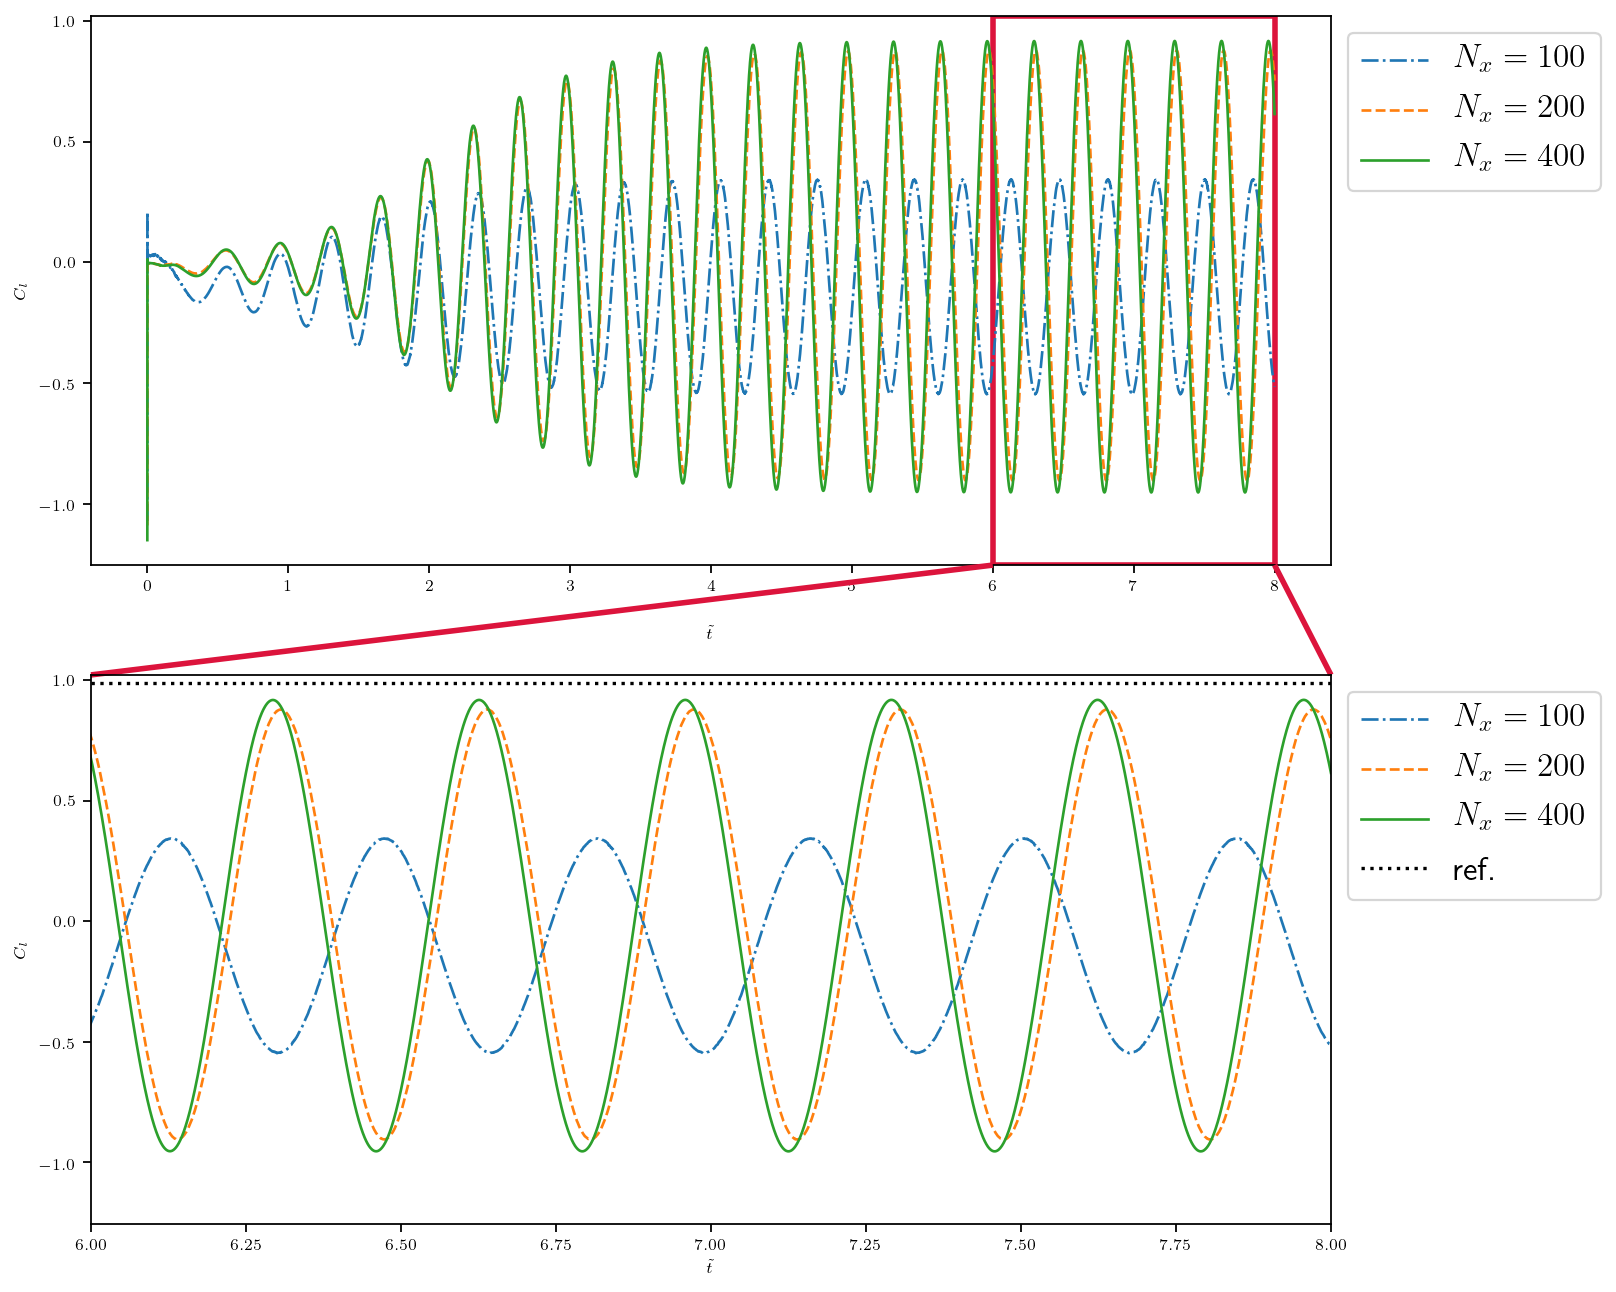

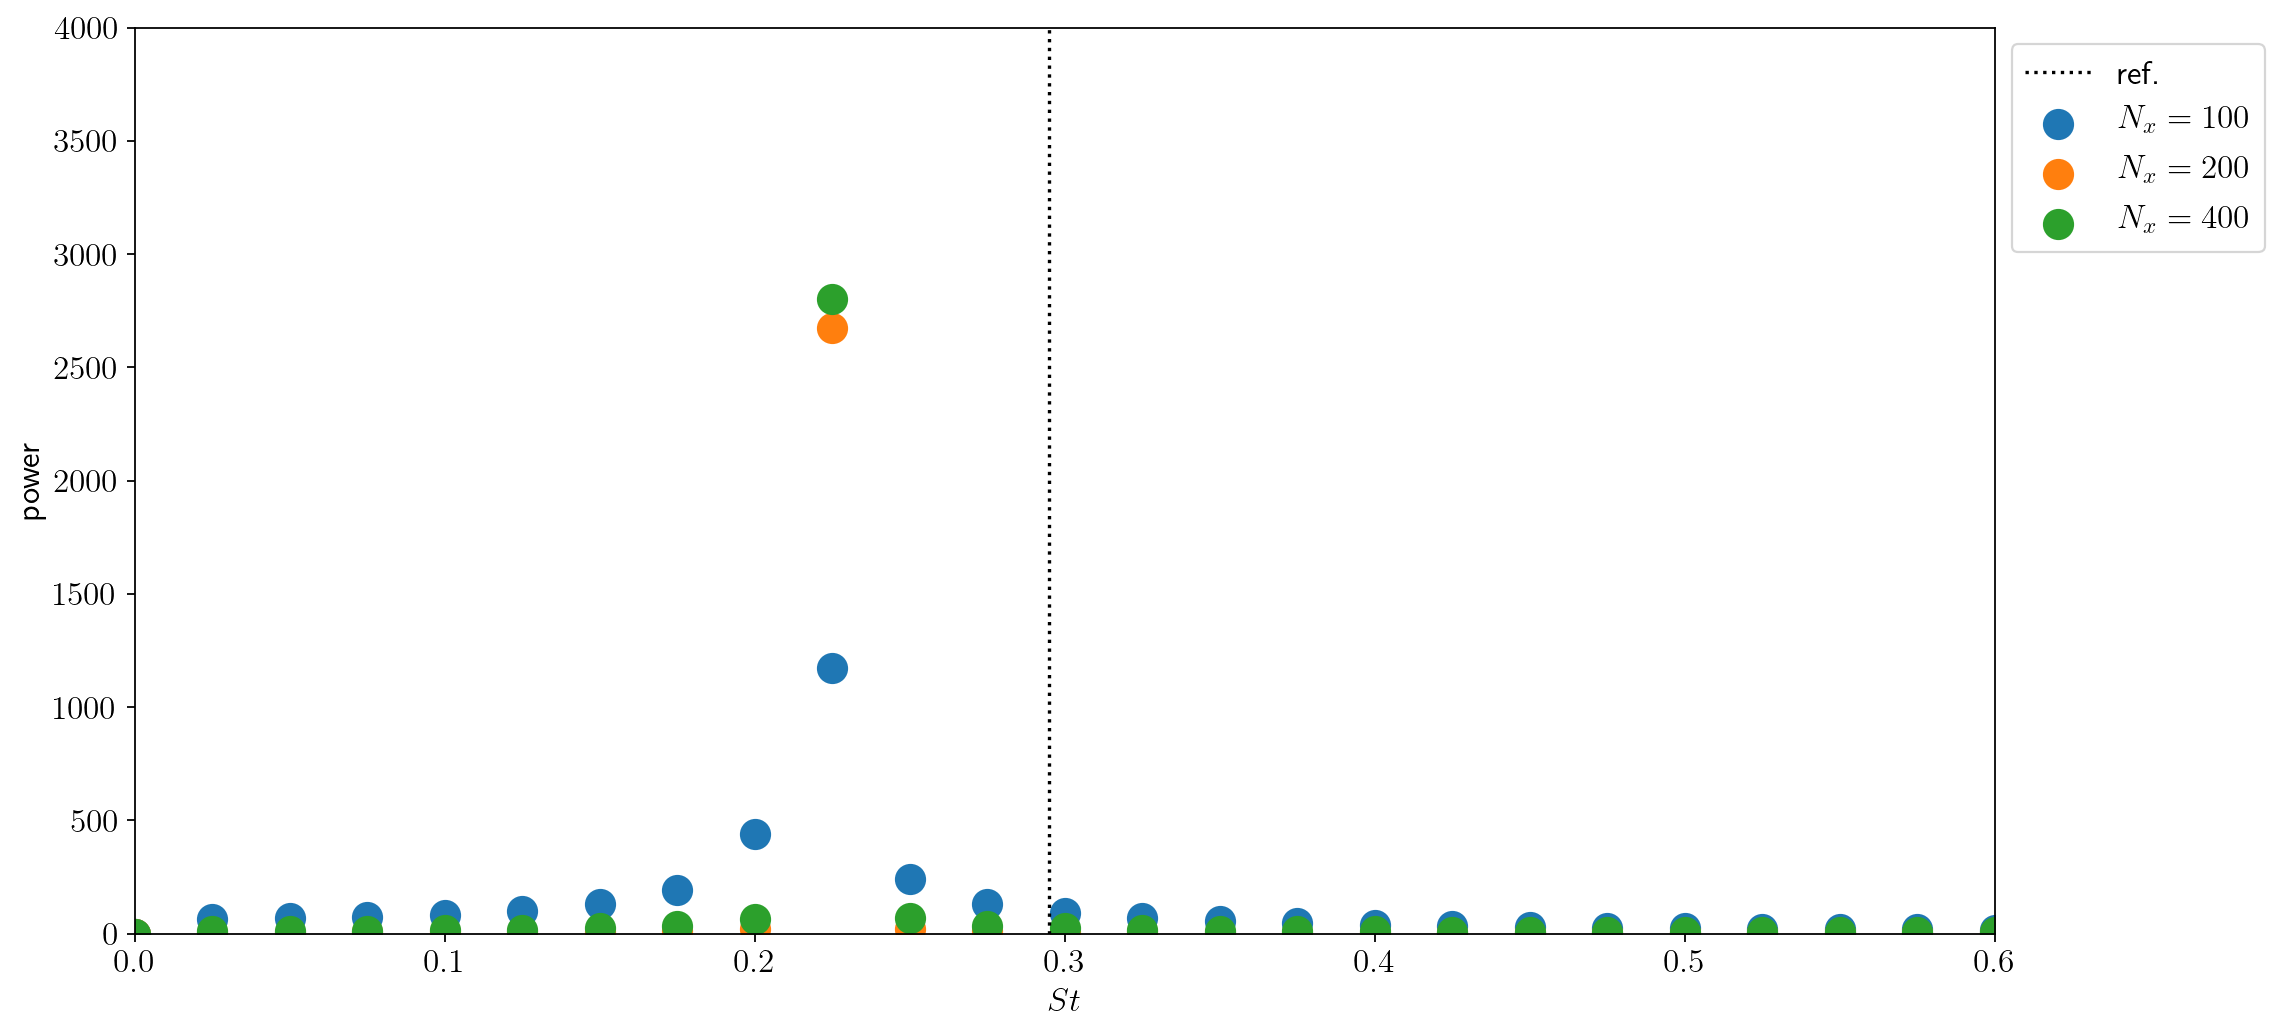

In [126]:
fig, (ax, axins) = plt.subplots(nrows=2,figsize=(10,10))
for i, case in enumerate(cases):
    ax.plot(data[case][0],data[case][2], ls=lines[i], linewidth=1.2, markevery=70, label=labels[i])
    axins.plot(data[case][0],data[case][2], ls=lines[i], linewidth=1.2, markevery=70, label=labels[i])
plt.rcParams.update({'font.size': 15})
axins.set_xlim((6,8))
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
axins.axhline(0.99, ls=":", color="k", label="ref.")
axins.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, linewidth=2.5, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, linewidth=2.5, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, linewidth=2.5, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

mark_inset(ax, axins, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="crimson") 
ax.set_ylabel(r"$C_l$")
ax.set_xlabel(r"$\tilde{t}$", labelpad=15)
axins.set_ylabel(r"$C_l$")
axins.set_xlabel(r"$\tilde{t}$")


#frequancy analysis
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
for i, case in enumerate(cases):
    freq, power = fft_cl[case]
    ax.scatter(freq[:100] * diameter, power[:100], s=170, label=labels[i])
    #ax1.plot(freq[:100] * diameter, power[:100], label=labels[i])
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))
ax.axvline(0.295, ls=":", color="k", label="ref.")
ax.set_xlabel("$St$")
ax.set_ylabel("power")
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 4000)
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
'''ax1.axvline(0.295, ls=":", color="k", label="ref.")
ax1.set_xlabel("$St$")
ax1.set_ylabel("power")
ax1.set_xlim(0, 0.6)
ax1.set_ylim(0, 4000)
ax1.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')'''

  Case no.  Case        Cell size(x)    min value after 5s(Cd)    mean value after 5s(Cd)    max value after 5s(Cd)
----------  --------  --------------  ------------------------  -------------------------  ------------------------
         1  case_100             100                   3.05413                    3.06098                   3.06604
         2  case_200             200                   3.14741                    3.17212                   3.19653
         3  case_400             400                   3.14756                    3.17533                   3.20258


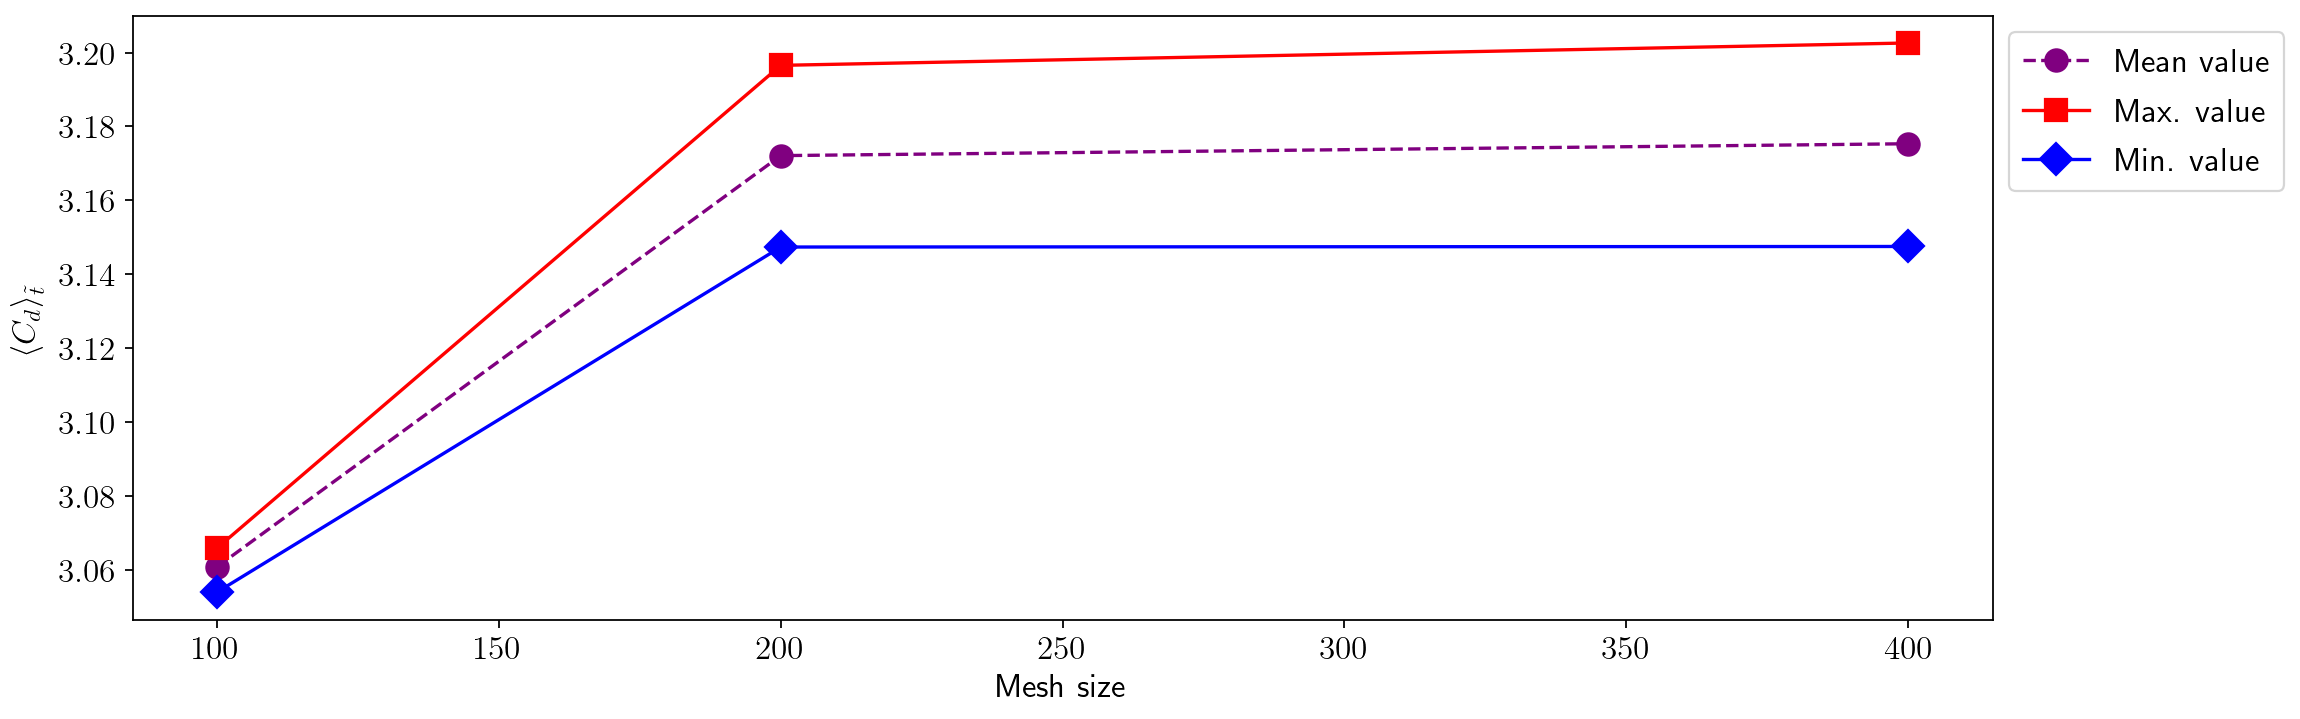

In [146]:
colors = ["red","blue","green"]
mean_cd = np.zeros(mesh_size.shape)
max_cd = np.zeros(mesh_size.shape)
min_cd = np.zeros(mesh_size.shape)
fig, ax = plt.subplots(1,1,figsize=(15,5))

for i, case in enumerate(cases):
    mean_cd[i] = data[case][1][tml:].mean()
    max_cd[i]  = data[case][1][tml:].max()
    min_cd[i]  = data[case][1][tml:].min()
ax.plot(mesh_size, mean_cd, '--o', markersize=10, color='Purple', label="Mean value")
ax.plot(mesh_size, max_cd, '-s', markersize=10, color='r', label="Max. value")
ax.plot(mesh_size, min_cd, '-D', markersize=10, color='b', label="Min. value")
ax.set_xlabel("Mesh size")
ax.set_ylabel(r"${\langle C_d \rangle}_{\tilde{t}}$")
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

#print mean values
p_data = [[0]*6]*len(mesh_size)
for i, case in enumerate(cases):
    p_data[i] = [i+1, case, mesh_size[i], min_cd[i], mean_cd[i], max_cd[i]]
print (tabulate(p_data, headers=["Case no.", "Case", "Cell size(x)", "min value after 5s(Cd)", "mean value after 5s(Cd)" , "max value after 5s(Cd)"]))

  Case no.  Case        Cell size(x)    min value after 5s(Cl)    mean value after 5s(Cl)    max value after 5s(Cl)
----------  --------  --------------  ------------------------  -------------------------  ------------------------
         1  case_100             100                 -0.546845                 -0.0906619                  0.343828
         2  case_200             200                 -0.904919                 -0.0126599                  0.878955
         3  case_400             400                 -0.953915                 -0.0164522                  0.918634


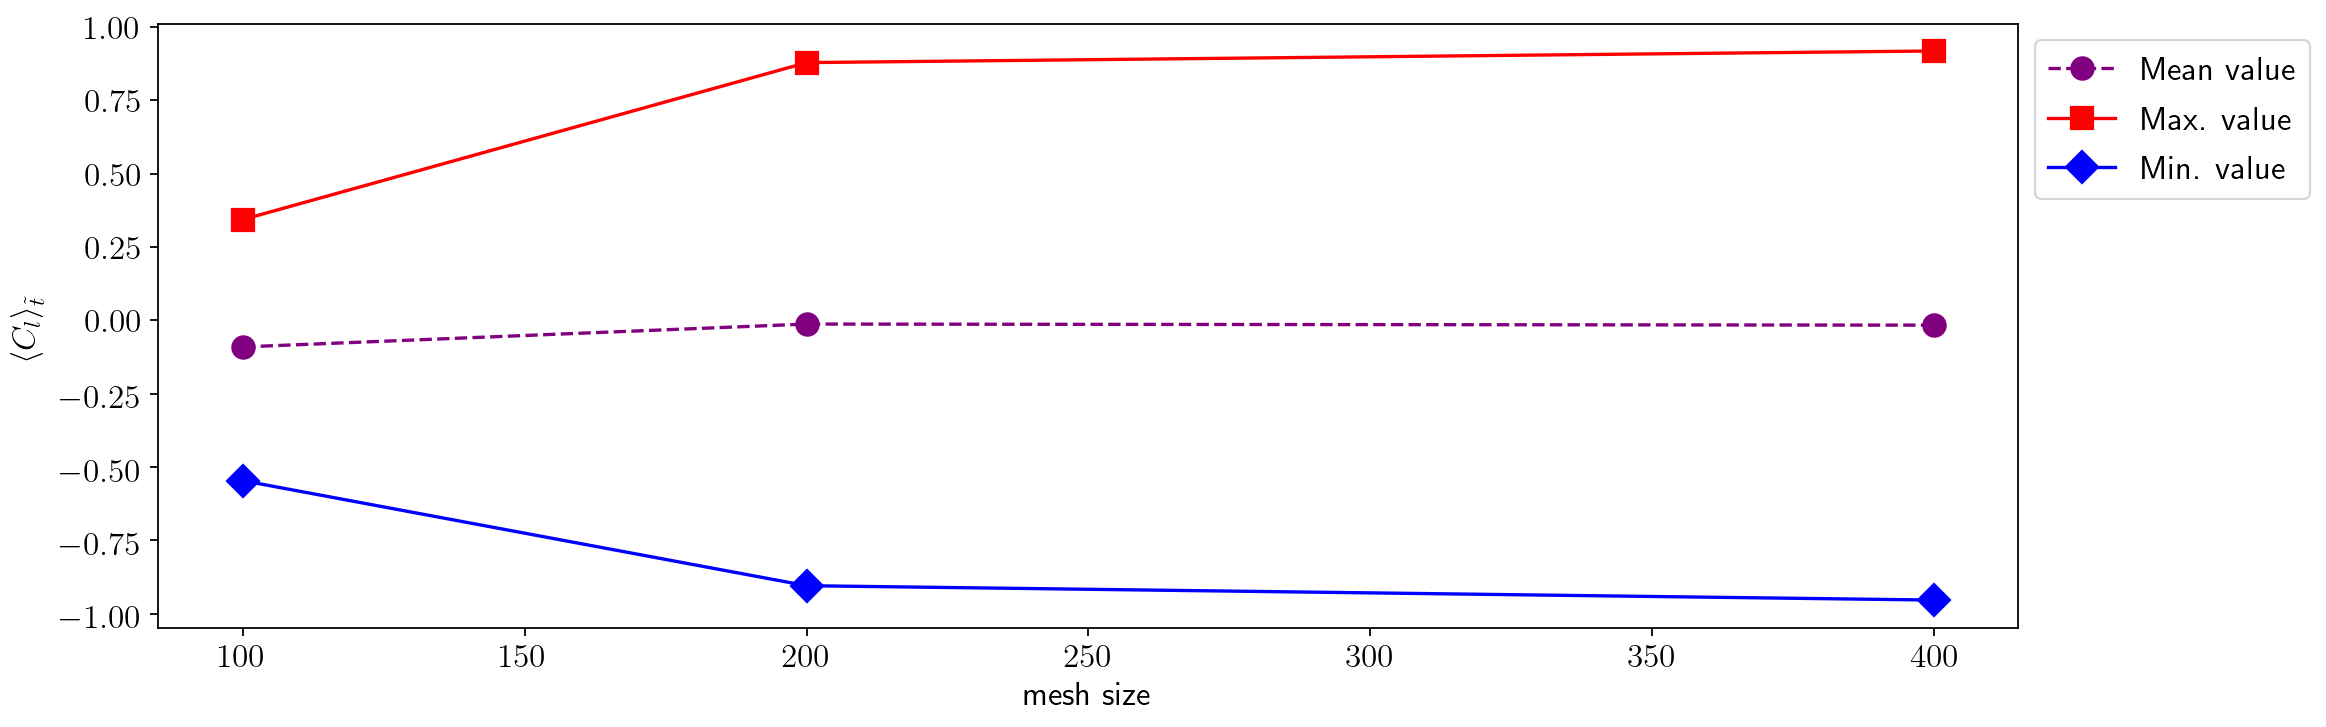

In [147]:
mean_cl = np.zeros(mesh_size.shape)
max_cl = np.zeros(mesh_size.shape)
min_cl = np.zeros(mesh_size.shape)
plot, ax = plt.subplots(1,1,figsize=(15,5))

for i, case in enumerate(cases):
    mean_cl[i] = data[case][2][tml:].mean()
    max_cl[i]  = data[case][2][tml:].max()
    min_cl[i]  = data[case][2][tml:].min()
ax.plot(mesh_size, mean_cl, '--o', color='purple', markersize=10, label="Mean value")
ax.plot(mesh_size, max_cl, '-s', color='r', markersize=10, label="Max. value")
ax.plot(mesh_size, min_cl, '-D', color='b', markersize=10, label="Min. value")
ax.set_xlabel("mesh size")
ax.set_ylabel(r"${\langle C_l \rangle}_{\tilde{t}}$")
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

#print mean/min/max values
header = ["Case no.", "Case", "Cell size(x)", "min value after 5s(Cl)", "mean value after 5s(Cl)", "max value after 5s(Cl)"]
p_data = [[0]*len(header)]*len(mesh_size)

for i, case in enumerate(cases):
    p_data[i] = [i+1, case, mesh_size[i], min_cl[i], mean_cl[i], max_cl[i]]
print (tabulate(p_data, headers=header))